In [1]:
import time
import numpy as np
import pickle
import awkward as ak
import dask_awkward as dak
from distributed import Client
from omegaconf import OmegaConf

from typing import Tuple, List, Dict
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
"""
Let's try VBF DNN
"""
load_path = f"/work/users/yun79/stage2_output/DNN_test/vbf/2018/processed_events_bkgMC*.parquet"
processed_events = ak.from_parquet(load_path)
region = processed_events.h_peak != 0
# DNN_score_raw is a sigmoid output
bkg = (ak.to_numpy(processed_events.DNN_score_sigmoid[region]))
bkg_wgt = (ak.to_numpy(processed_events.wgt_nominal_total[region]))
bkg_label = 0*np.ones_like(bkg)
load_path = f"/work/users/yun79/stage2_output/DNN_test/vbf/2018/processed_events_sigMC*.parquet"
processed_events = ak.from_parquet(load_path)
region = processed_events.h_peak != 0
sig = (ak.to_numpy(processed_events.DNN_score_sigmoid[region]))
sig_wgt = (ak.to_numpy(processed_events.wgt_nominal_total[region]))
sig_label = np.ones_like(sig)
print(np.min(bkg))
print(np.max(bkg))
print(np.min(sig))
print(np.max(sig))
print(bkg.shape)
print(sig.shape)
pred = np.concatenate((bkg,sig), axis=0)
wgt_total = np.concatenate((bkg_wgt,sig_wgt), axis=0)
label = np.concatenate((bkg_label,sig_label), axis=0)
print(pred.shape)
print(wgt_total.shape)
print(label.shape)

0.013976231217384338
0.8325756192207336
0.017451362684369087
0.8958308100700378
(20638,)
(99566,)
(120204,)
(120204,)
(120204,)


In [5]:
def customROC_curve_AN(label, pred, weight):
    """
    generates signal and background efficiency consistent with the AN,
    as described by Fig 4.6 of Dmitry's PhD thesis
    """
    # we assume sigmoid output with labels 0 = background, 1 = signal
    thresholds = np.linspace(start=0,stop=1, num=50) 
    effBkg_total = -99*np.ones_like(thresholds) # effBkg = false positive rate
    effSig_total = -99*np.ones_like(thresholds) # effSig = true positive rate
    for ix in range(len(thresholds)):
        threshold = thresholds[ix]
        # get FP and TP
        positive_filter = (pred > threshold)
        falsePositive_filter = positive_filter & (label == 0)
        FP = np.sum(weight[falsePositive_filter])#  FP = false positive
        truePositive_filter = positive_filter & (label == 1)
        TP = np.sum(weight[truePositive_filter])#  TP = true positive
        

        # get TN and FN
        negative_filter = (pred <= threshold) # just picked negative to be <=
        trueNegative_filter = negative_filter & (label == 0)
        TN = np.sum(weight[trueNegative_filter])#  TN = true negative
        falseNegative_filter = negative_filter & (label == 1)
        FN = np.sum(weight[falseNegative_filter])#  FN = false negative

        

        # effBkg = TN / (FN + TN)
        # effSig = TP / (TP + FP)
        # effBkg = TN / (FP + TN)
        # effSig = TP / (TP + FN)
        effBkg = TN / (TN + FP)
        effSig = FN / (FN + TP)
        effBkg_total[ix] = effBkg
        effSig_total[ix] = effSig

        # print(f"TN: {TN}")
        # print(f"FN: {FN}")
        
        # sanity check
        assert ((np.sum(positive_filter) + np.sum(negative_filter)) == len(pred))
        total_yield = FP + TP + FN + TN
        assert(np.isclose(total_yield, np.sum(weight)))
        # print(f"total_yield: {total_yield}")
        # print(f"np.sum(weight): {np.sum(weight)}")
    print(f"np.sum(effBkg_total ==-99) : {np.sum(effBkg_total ==-99)}")
    print(f"np.sum(effSig_total ==-99) : {np.sum(effSig_total ==-99)}")
    effBkg_total[np.isnan(effBkg_total)] = 1
    effSig_total[np.isnan(effSig_total)] = 1
    return (effBkg_total, effSig_total, thresholds)



np.sum(effBkg_total ==-99) : 0
np.sum(effSig_total ==-99) : 0


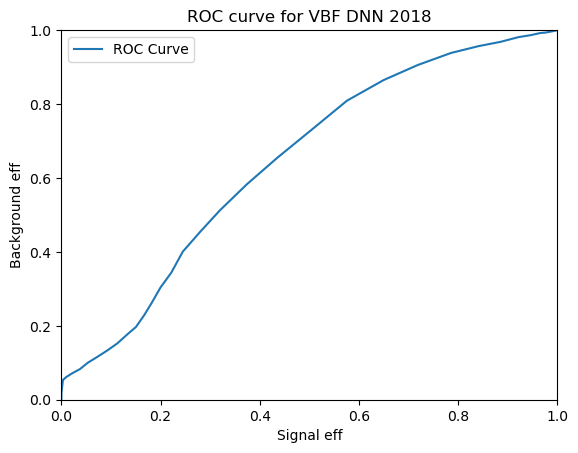

In [6]:
eff_bkg, eff_sig, thresholds = customROC_curve_AN(label, pred, wgt_total)
plt.figure()  
plt.plot(eff_sig, eff_bkg, label="ROC Curve")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Signal eff')
plt.ylabel('Background eff')
plt.title('ROC curve for VBF DNN 2018')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.show()